<a href="https://colab.research.google.com/github/leyixu21/master_thesis/blob/main/clean_flickr_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparations

In [2]:
! pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.9 MB/s 
     |████████████████████████████████| 6.3 MB 47.3 MB/s 
     |████████████████████████████████| 16.7 MB 24.8 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

path='/content/drive/MyDrive/master_thesis_data/'

Mounted at /content/drive


In [131]:
import pandas as pd
from pandas.io.formats.format import NA
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt

import folium

import geopandas as gpd

# Preprocess Flick Data

## Clean Data

In [5]:
# read boundary data
london = gpd.read_file(path+'london_boundaries.geojson')
london.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [250]:
# read data
output_geojson = 'london_flickr_'
y = 2021

gdf = gpd.read_file(path+output_geojson+str(y)+'.geojson')

# get column names
gdf.columns

Index(['Unnamed: 0', 'accuracy', 'context', 'datetaken',
       'datetakengranularity', 'datetakenunknown', 'farm', 'geo_is_contact',
       'geo_is_family', 'geo_is_friend', 'geo_is_public', 'height_n', 'id',
       'isfamily', 'isfriend', 'ispublic', 'latitude', 'license', 'longitude',
       'machine_tags', 'owner', 'place_id', 'secret', 'server', 'tags',
       'title', 'url_n', 'views', 'width_n', 'woeid', 'geometry'],
      dtype='object')

In [251]:
# select necessary columns
gdf = gdf[['owner', 'accuracy', 'datetaken', 'datetakenunknown', 'tags', 'title', 'geometry']]

# convert string to datetime format
gdf['datetaken'] = pd.to_datetime(gdf['datetaken'], format='%Y-%m-%d %H:%M:%S')
# get date
gdf['date'] = gdf['datetaken'].apply(lambda x: x.date())
# sort by datetaken
gdf = gdf.sort_values(by='datetaken')

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [252]:
# remove photos with no tags
gdf = gdf.dropna(subset=['tags'])

In [253]:
# remove photos with accuracy lower than 14
gdf = gdf[gdf['accuracy']>=14]

### Clean Tags

In [254]:
# remove non-English tags and tags with non-Ascii characters, special characters, numbers, and stop-word

# define a function to detect non-Ascii characters
def containsNonAscii(s):
  return any(ord(i)>127 for i in s)

# define a function to detect special characters and numbers
def containsNonSpecialChar(s):
  return bool(re.match('^[a-zA-Z]*$',s))

# define a function to detect stop-words
def containsNonStopW(s):
  return s != 'a' and s != 'an' and s != 'the'

# define a function to detect general place names
def containsNonGeneralP(s):
  general_places = ['britain', 'united', 'kingdom', 'uk', 'england', 'london']
  return all(x not in s for x in general_places)

for i, row in gdf.iterrows():
  # split the tag string to the list
  words = row['tags'].split()
  cleaned_words = [word for word in words if not containsNonAscii(word)]
  cleaned_words = [word for word in cleaned_words if containsNonSpecialChar(word)]
  cleaned_words = [word for word in cleaned_words if containsNonStopW(word)]
  cleaned_words = [word for word in cleaned_words if containsNonGeneralP(word)]
  # remove duplicates in the same tag list
  cleaned_words = list(set(cleaned_words))
  # convert the tag list back to the string
  cleaned_words = ' '.join(cleaned_words)
  gdf['tags'][i] = cleaned_words

# remove photos with no tags again
gdf = gdf.dropna(subset=['tags'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [255]:
# remove duplicates
gdf = gdf.drop_duplicates(subset=['owner', 'tags', 'datetaken'])

In [256]:
# get all tags
tags = list(gdf['tags'].apply(lambda x: x.split()))
# flatten the tags list to 1d
tags = list(np.concatenate(tags).flat)

# count tags
tags_count = Counter(tags)

# get the list of unique tags
tags_unique = list(tags_count.keys())

### Clean Users

In [257]:
# group data by users
gdf_gb_users = gdf.groupby('owner')

# get the list of users
users = list(gdf_gb_users.groups.keys())

In [258]:
# get users less than 5 photos in total at different places over a 24-h period
# iterate the users
for i in users:
  user = gdf_gb_users.get_group(i)
  # group data of the specific user by date
  user_gb_date = user.groupby('date', as_index=False)
  # count the number of photos this user took each day
  user_gb_date_count = user_gb_date.count()
  # get the list of dates when the photos were less than 5
  date_sparse = user_gb_date_count[user_gb_date_count['tags'] < 5].date.to_list()
  # remove users who uploaded sparse photos within a day
  gdf = gdf[(gdf['owner'] != i) | (~gdf['date'].isin(date_sparse))]


# group data by users again
gdf_gb_users = gdf.groupby('owner', as_index=False)

# get the list of users
users = list(gdf_gb_users.groups.keys())

In [259]:
# remove prolific users who uploaded more than 5% photos of the whole dataset
# count the number of photos each user uploaded
gdf_gb_users_count = pd.DataFrame(gdf_gb_users.count())
# calculate the percent of photos each user uploaded
gdf_gb_users_count['percent'] = (gdf_gb_users_count['tags'] / gdf_gb_users_count['tags'].sum()) * 100
gdf_gb_users_count = gdf_gb_users_count.sort_values('percent', ascending=False)

# get the id of users who uploaded too many photos
users_prolific = gdf_gb_users_count[gdf_gb_users_count['percent'] > 5].owner
# remove prolific users
gdf = gdf[~gdf['owner'].isin(users_prolific)]


# group data by users again
gdf_gb_users = gdf.groupby('owner', as_index=False)

# get the list of users
users = list(gdf_gb_users.groups.keys())

In [ ]:
# visualize the distribution of photos taken by the specific user
user_test = gdf_gb_users.get_group('64639998@N00')

map = folium.Map(location = [51.9,0], zoom_start = 10)

for date, title, tags, geometry in user_test[['datetaken', 'title', 'tags', 'geometry']].values:
    # Place the markers with the popup labels and data
    folium.Marker(location = [geometry.xy[1][0], geometry.xy[0][0]],
                  tooltip ='<strong>Date: </strong>{0}<br><strong>Title: </strong>{1}</br><strong>Tags: </strong>{2}'.format(date, title, tags)
                  ).add_to(map)

map


## Check Data Quality

In [ ]:
# plot the user profile histogram showing the top 20 prolific users


In [ ]:
# plot the tag profile histogram of prolific users

In [ ]:
# plot the tag profile histogram of all users

In [ ]:
# plot xxx

## Visualize Data

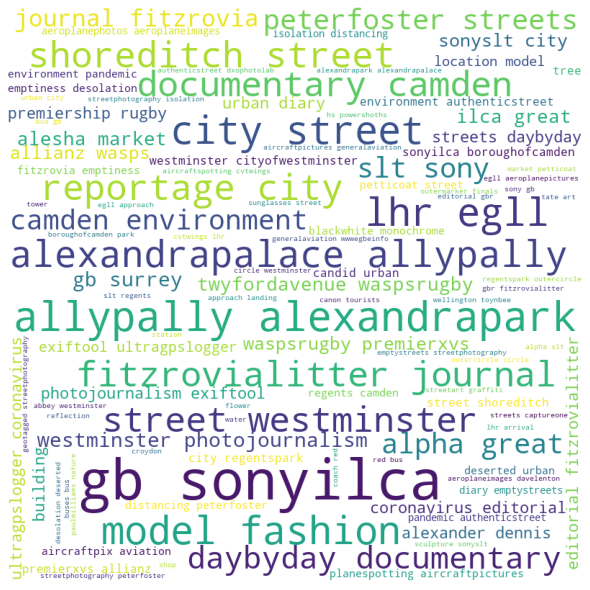

In [261]:
# Python program to generate WordCloud

# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd


comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in tags:
  # split the value
  tokens = val.split()
  
  # Converts each token into lowercase
  for i in range(len(tokens)):
    tokens[i] = tokens[i].lower()
  
  comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
				background_color ='white',
				stopwords = stopwords,
				min_font_size = 10).generate(comment_words)

# plot the WordCloud image					
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


In [260]:
tags

['churchhall',
 'stmarys',
 'barnet',
 'eastbarnetvillage',
 'newyearsday',
 'churchhillroad',
 'stmaryschurchhall',
 'eastbarnet',
 'churchhall',
 'stmarys',
 'barnet',
 'eastbarnetvillage',
 'newyearsday',
 'churchhillroad',
 'stmaryschurchhall',
 'eastbarnet',
 'door',
 'churchhall',
 'stmarys',
 'barnet',
 'eastbarnetvillage',
 'newyearsday',
 'churchhillroad',
 'stmaryschurchhall',
 'eastbarnet',
 'churchhall',
 'stmarys',
 'barnet',
 'eastbarnetvillage',
 'newyearsday',
 'churchhillroad',
 'stmaryschurchhall',
 'eastbarnet',
 'churchhall',
 'stmarys',
 'barnet',
 'eastbarnetvillage',
 'newyearsday',
 'churchhillroad',
 'stmaryschurchhall',
 'eastbarnet',
 'thepropertystudio',
 'estateagent',
 'tps',
 'barnet',
 'eastbarnetvillage',
 'shopwindow',
 'churchhillroad',
 'eastbarnet',
 'fishisland',
 'black',
 'january',
 'teddington',
 'monochrome',
 'white',
 'january',
 'pathway',
 'winter',
 'tree',
 'kit',
 'truck',
 'olympus',
 'model',
 'mft',
 'microfourthirds',
 'mazda',
 'wa